In [1]:
#Importar librerías
import statsmodels.api as sm
import pandas as pd
import geopandas as gpd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import libpysal
from libpysal.weights import Queen
from esda.moran import Moran, Moran_Local
from splot.esda import moran_scatterplot, lisa_cluster
from statsmodels.stats.stattools import jarque_bera, omni_normtest
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from spreg import ML_Lag
import numpy as np
from scipy.stats import norm, t, shapiro, jarque_bera, normaltest
from sklearn.preprocessing import StandardScaler
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR, MGWR

In [23]:
#Añadir datos
data = gpd.read_file("datos_censales_3.shp")
data

,CUSEC,poblacion,area,densidad,edad_media,por_menore,por_mayore,por_no_lab,por_españ,por_estudi,...,por_paro,gini,comercios,densidad_c,densidad_a,por_extran,indice_sin,Shape_Leng,Shape_Area,geometry
0,4109101001,1332,0.058314,22841.686951,43.9,15.2,17.3,32.5,92.9,66.3,...,57.5,31.2,30,514.45200,651.639718,7.1,0.027104,1126.577465,5.831443e+04,"POLYGON ((235754.655 4142933.173, 235737.735 4..."
1,4109101002,879,0.048849,17994.107138,44.8,13.7,20.1,33.8,91.9,61.8,...,51.7,32.8,16,327.53800,757.431131,8.1,-0.606919,1036.337346,4.884933e+04,"POLYGON ((235509.850 4143032.668, 235507.177 4..."
2,4109101003,642,0.028793,22297.141799,46.0,11.8,20.6,32.4,88.4,59.9,...,50.0,32.3,19,659.88400,937.730263,11.6,0.118666,1178.482189,2.879293e+04,"POLYGON ((235213.742 4143085.673, 235268.147 4..."
3,4109101004,804,0.054559,14736.370999,46.4,16.4,24.3,40.7,90.2,60.8,...,48.5,33.4,28,513.20700,623.179868,9.8,-0.228750,1064.549591,5.455889e+04,"POLYGON ((235489.906 4142864.425, 235480.503 4..."
4,4109101005,769,0.047157,16307.342728,45.9,12.4,20.7,33.1,90.7,60.9,...,50.0,33.5,40,848.23600,1039.089459,9.3,-0.032558,993.008101,4.715667e+04,"POLYGON ((235276.052 4142883.174, 235286.956 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,4109109069,1163,10.346479,112.405388,35.0,24.0,5.0,29.0,97.1,7.6,...,62.4,30.4,12,1.15981,0.000000,2.9,-0.202396,18273.043604,5.774604e+06,"MULTIPOLYGON (((241749.537 4143117.004, 242126..."
520,4109101037,1193,0.676088,1764.563243,49.0,12.3,30.1,42.4,90.8,62.7,...,62.9,38.1,143,211.51100,380.128041,9.2,-0.167958,4073.824254,6.053994e+05,"POLYGON ((234982.614 4142051.989, 234999.547 4..."
521,4109110010,1148,0.739531,1552.334704,45.5,14.8,25.0,39.8,93.0,63.5,...,53.5,32.8,46,62.20160,1.352208,7.0,-0.163986,4071.494586,5.999577e+05,"POLYGON ((235600.127 4139244.239, 235606.287 4..."
522,4109111001,2054,14.076732,145.914549,39.2,26.7,16.4,43.1,97.5,65.4,...,53.1,25.0,15,1.06559,0.142078,2.5,-0.201825,13691.125483,3.304420e+06,"POLYGON ((233131.820 4140029.172, 233139.772 4..."


In [24]:
# Variables de interés
variables = ['densidad', 'alimentaci', 'comercio', 'servicios', 
             'educacion', 'salud', 'transporte', 'ocio', 'areas_verd']

# Crear Dataframe solo con esas variables
df = data[variables]

KeyError: "['alimentaci', 'comercio', 'servicios', 'educacion', 'salud', 'transporte', 'ocio', 'areas_verd'] not in index"

In [32]:
df = data
df = df.select_dtypes(include=['int64', 'float64'])

In [33]:
# Función para análisis exploratorio 
def analisis_exploratorio(df):
    resumen = pd.DataFrame(index=df.columns)
    resumen['media'] = df.mean()
    resumen['mediana'] = df.median()
    resumen['moda'] = df.mode().iloc[0]
    resumen['desv_std'] = df.std()
    resumen['varianza'] = df.var()
    resumen['rango'] = df.max() - df.min()
    resumen['iqr'] = df.quantile(0.75) - df.quantile(0.25)
    resumen['asimetria'] = df.apply(stats.skew)
    resumen['curtosis'] = df.apply(stats.kurtosis)
    resumen['p25'] = df.quantile(0.25)
    resumen['p75'] = df.quantile(0.75)
    resumen['min'] = df.min()
    resumen['max'] = df.max()
    return resumen.round(2)

eda = analisis_exploratorio(df)
print(eda)

                media   mediana      moda   desv_std      varianza  \
poblacion     1290.65   1237.00    806.00     414.68  1.719585e+05   
area             0.27      0.06      0.01       1.34  1.800000e+00   
densidad     22545.47  20665.09     81.46   12894.84  1.662770e+08   
edad_media      44.00     44.85     46.00       4.15  1.724000e+01   
por_menore      16.63     15.70     13.70       4.44  1.971000e+01   
por_mayore      21.11     21.90     22.90       7.60  5.782000e+01   
por_no_lab      37.73     37.55     35.40       5.71  3.264000e+01   
por_españ       93.57     95.25     97.90       5.49  3.010000e+01   
por_estudi      37.69     35.35     76.00      22.75  5.174900e+02   
por_sin_es      62.31     64.65     24.00      22.75  5.174900e+02   
por_unidim      28.19     28.10     31.10       7.75  6.004000e+01   
renta        33421.17  31318.50  14650.00   12095.46  1.463000e+08   
salario       9031.82   9052.50   2019.00    3653.02  1.334458e+07   
tasa_emple      55.9

In [34]:
# Función para interpretar estadísticos (sin cambios)
def interpretar_estadisticas(df_stats, df_datos):
    n = len(df_datos)
    for var in df_stats.index:
        skew = df_stats.loc[var, 'asimetria']
        kurt = df_stats.loc[var, 'curtosis']
        std = df_stats.loc[var, 'desv_std']
        mean = df_stats.loc[var, 'media']
        median = df_stats.loc[var, 'mediana']
        q1 = df_stats.loc[var, 'p25']
        q3 = df_stats.loc[var, 'p75']
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        datos_var = df_datos[var]
        dentro_iqr = datos_var[(datos_var >= q1) & (datos_var <= q3)]
        n_dentro_iqr = len(dentro_iqr)
        pct_dentro_iqr = n_dentro_iqr / n * 100
        cv = (std / mean * 100) if mean != 0 else float('inf')
        outliers = datos_var[(datos_var < lower_bound) | (datos_var > upper_bound)]
        n_outliers = len(outliers)
        pct_outliers = n_outliers / n * 100

        print(f"\nVariable: {var}")
        diff = mean - median
        if abs(diff) < 0.01 * abs(mean) if mean != 0 else abs(diff) < 0.01:
            print(f" - Media y mediana muy similares ({mean:.3f} vs {median:.3f}), distribución posiblemente simétrica.")
        elif diff > 0:
            print(f" - Media ({mean:.3f}) > mediana ({median:.3f}): posible sesgo a la derecha.")
        else:
            print(f" - Media ({mean:.3f}) < mediana ({median:.3f}): posible sesgo a la izquierda.")
        if skew > 0.5:
            print(f" - Sesgo: sesgo a la derecha (asimetría = {skew:.3f})")
        elif skew < -0.5:
            print(f" - Sesgo: sesgo a la izquierda (asimetría = {skew:.3f})")
        else:
            print(f" - Sesgo: aproximadamente simétrica (asimetría = {skew:.3f})")
        if std > abs(mean)*0.5:
            print(f" - Dispersión: alta desviación estándar ({std:.3f}) relativa a media ({mean:.3f})")
        else:
            print(f" - Dispersión: baja/moderada desviación estándar ({std:.3f}) relativa a media ({mean:.3f})")
        if cv < 0.1:
            print(f" - Coeficiente de variación (CV = {cv:.3f}): variabilidad muy baja (datos muy homogéneos).")
        elif cv < 0.3:
            print(f" - Coeficiente de variación (CV = {cv:.3f}): variabilidad baja/moderada.")
        elif cv < 0.5:
            print(f" - Coeficiente de variación (CV = {cv:.3f}): variabilidad moderada/alta.")
        else:
            print(f" - Coeficiente de variación (CV = {cv:.3f}): variabilidad muy alta (datos heterogéneos).")
        if kurt > 3:
            print(f" - Curtosis: leptocúrtica (colas pesadas, curtosis = {kurt:.3f})")
        elif kurt < 3:
            print(f" - Curtosis: platicúrtica (colas ligeras, curtosis = {kurt:.3f})")
        else:
            print(f" - Curtosis: mesocúrtica (≈ 3, curtosis = {kurt:.3f})")
        print(f" - {n_dentro_iqr} datos ({pct_dentro_iqr:.1f}%) dentro del rango IQR [{q1:.3f}, {q3:.3f}]")
        print(f" - {n_outliers} datos ({pct_outliers:.1f}%) posibles outliers (fuera 1.5*IQR)")

interpretar_estadisticas(eda, df)


Variable: poblacion
 - Media (1290.650) > mediana (1237.000): posible sesgo a la derecha.
 - Sesgo: sesgo a la derecha (asimetría = 0.660)
 - Dispersión: baja/moderada desviación estándar (414.680) relativa a media (1290.650)
 - Coeficiente de variación (CV = 32.130): variabilidad muy alta (datos heterogéneos).
 - Curtosis: platicúrtica (colas ligeras, curtosis = 0.110)
 - 263 datos (50.2%) dentro del rango IQR [972.000, 1547.250]
 - 5 datos (1.0%) posibles outliers (fuera 1.5*IQR)

Variable: area
 - Media (0.270) > mediana (0.060): posible sesgo a la derecha.
 - Sesgo: sesgo a la derecha (asimetría = 8.130)
 - Dispersión: alta desviación estándar (1.340) relativa a media (0.270)
 - Coeficiente de variación (CV = 496.296): variabilidad muy alta (datos heterogéneos).
 - Curtosis: leptocúrtica (colas pesadas, curtosis = 68.360)
 - 246 datos (46.9%) dentro del rango IQR [0.040, 0.100]
 - 52 datos (9.9%) posibles outliers (fuera 1.5*IQR)

Variable: densidad
 - Media (22545.470) > mediana 

C:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Usuario\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `n

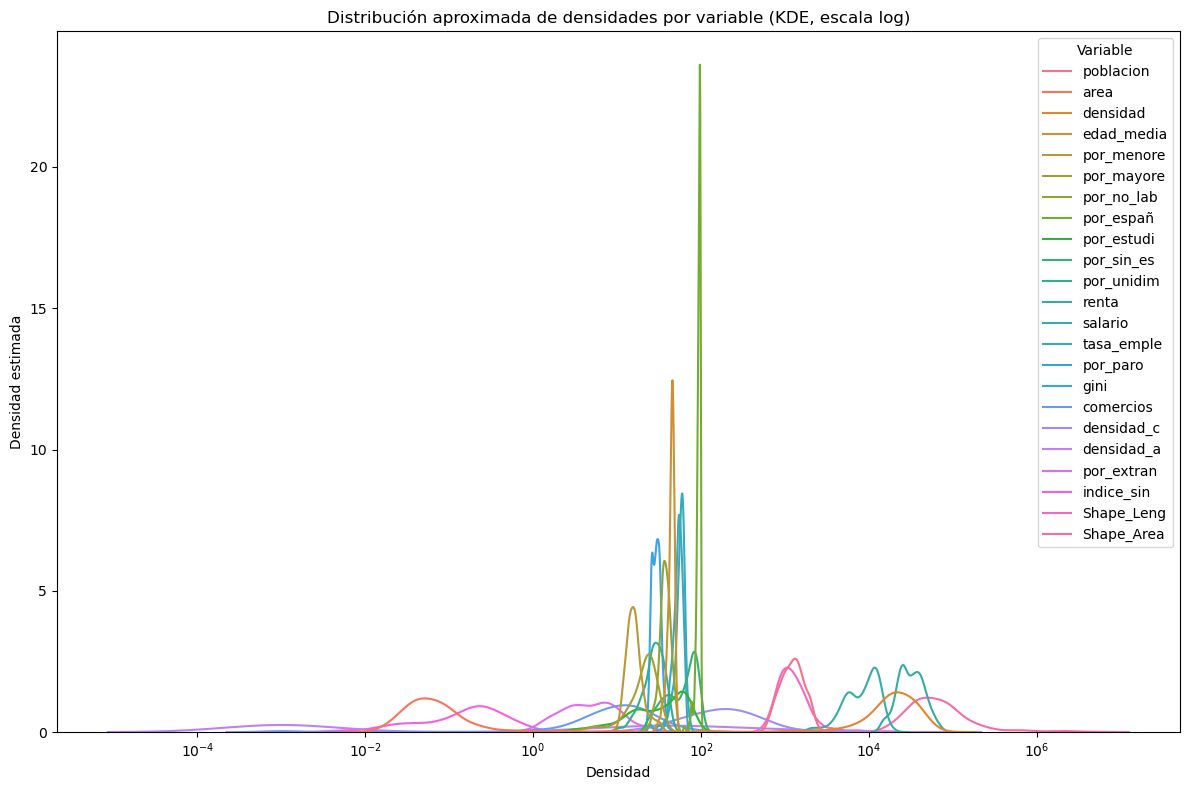

In [35]:
# Copiamos el DataFrame para no tocar el original
df_plot = df.copy()

# Reemplazamos ceros por un valor muy pequeño para que funcione la escala log
df_plot = df_plot.replace(0, 0.001)

# Pasar a formato largo
df_melt = df_plot.melt(var_name="Variable", value_name="Densidad")

# Gráfico de distribuciones KDE
plt.figure(figsize=(12, 8))
sns.kdeplot(
    data=df_melt,
    x="Densidad",
    hue="Variable",
    log_scale=True,   # Escala log para captar diferencias
    common_norm=False # No normalizar todas juntas
)

plt.title("Distribución aproximada de densidades por variable (KDE, escala log)")
plt.xlabel("Densidad")
plt.ylabel("Densidad estimada")
plt.tight_layout()
plt.show()

C:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Usuario\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `n

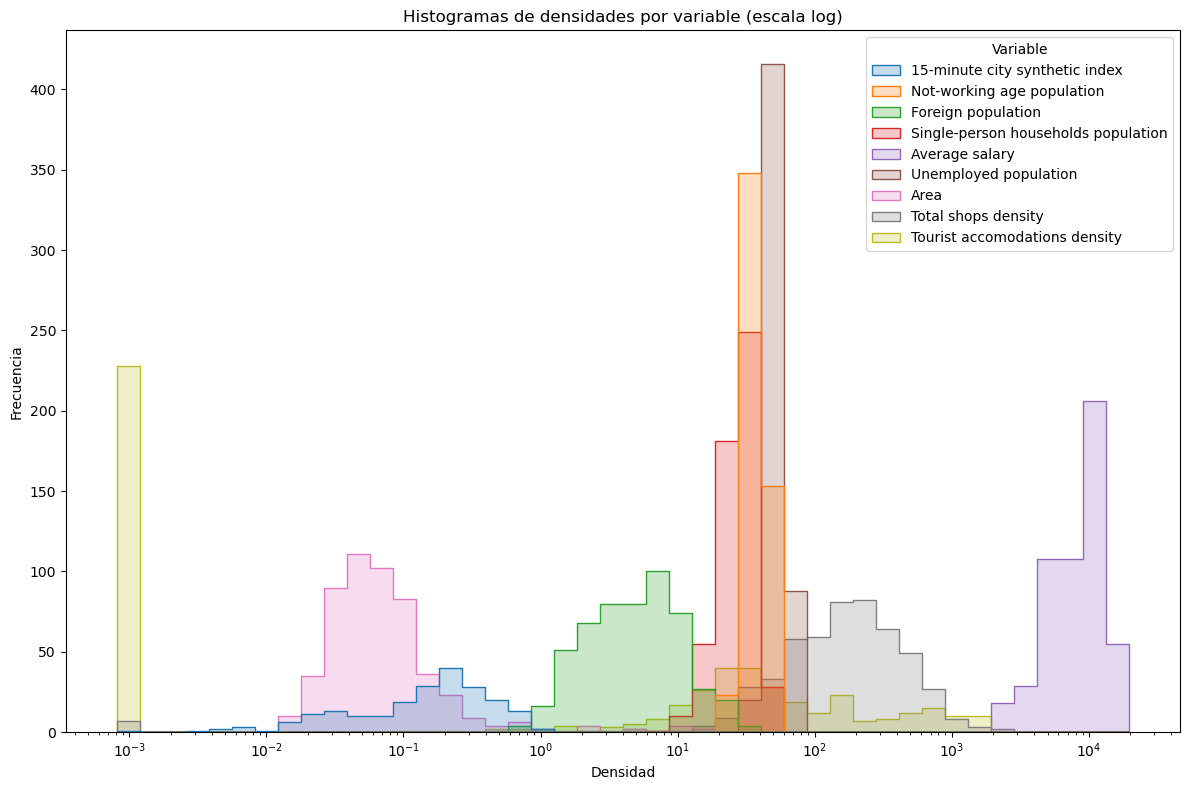

In [42]:
# Copiamos el dataframe para no modificar el original
df_plot = df.copy()

# Reemplazar ceros por un valor pequeño para usar escala logarítmica
df_plot = df_plot.replace(0, 0.001)

# Transformar a formato largo para Seaborn
df_melt = df_plot.melt(var_name="Variable", value_name="Densidad")

# Graficar histogramas
plt.figure(figsize=(12, 8))
sns.histplot(
    data=df_melt,
    x="Densidad",
    hue="Variable",
    element="step",
    common_norm=False,
    log_scale=True  # Escala logarítmica para el eje X
)
plt.title("Histogramas de densidades por variable (escala log)")
plt.xlabel("Densidad")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

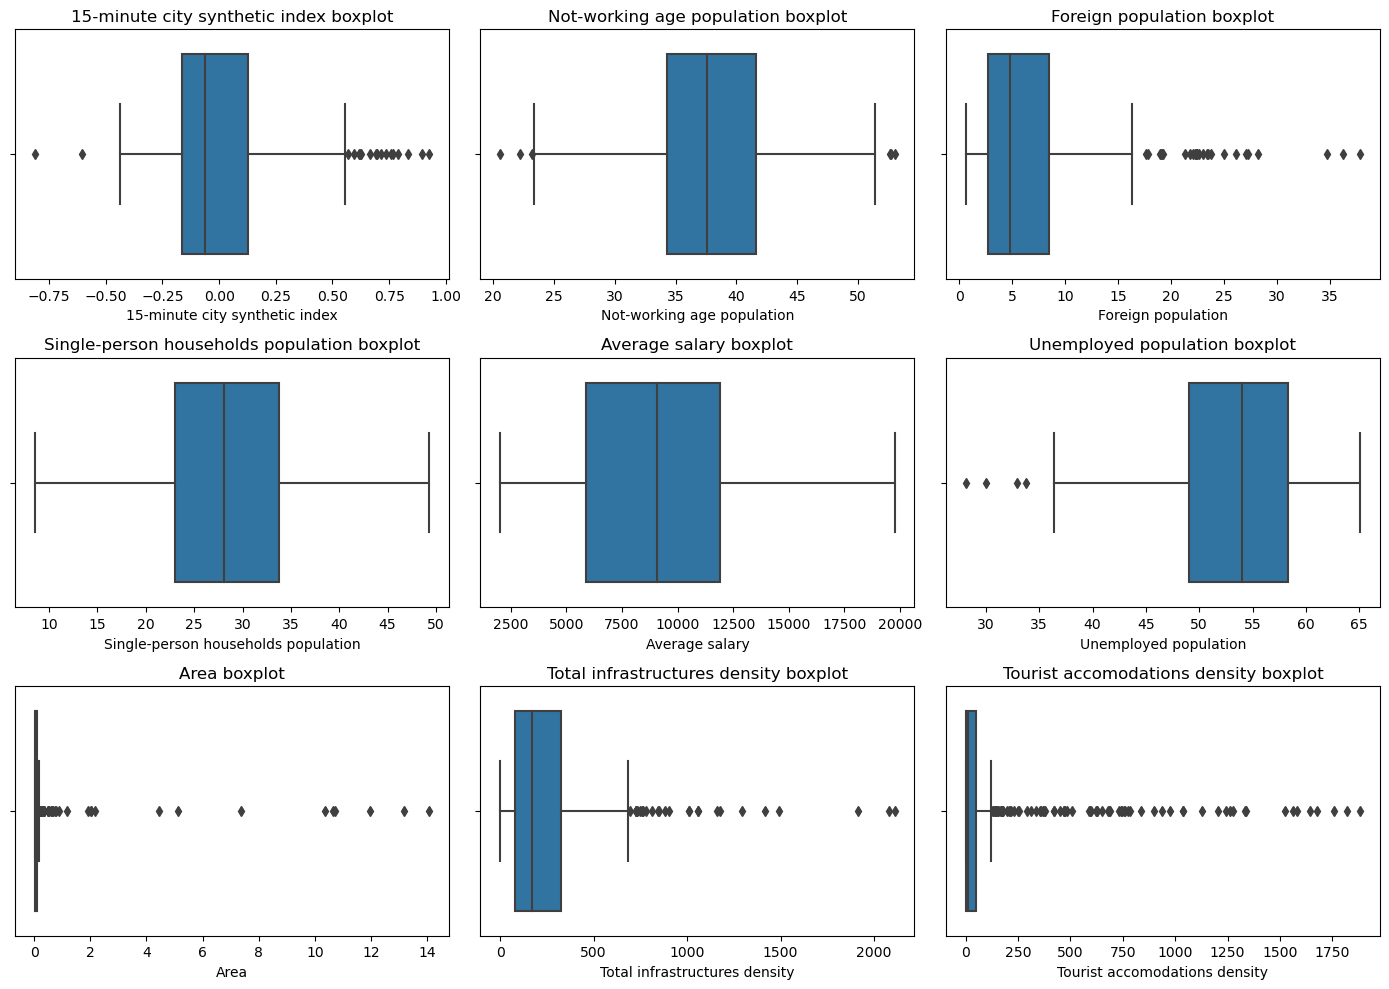

In [49]:
# Boxplots para detectar outliers y ver dispersión
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(14,10))
for i, col in enumerate(df.columns, 1):
    plt.subplot(3,3,i)
    sns.boxplot(x=df[col])
    plt.title(f'{col} boxplot')
plt.tight_layout()
plt.show()

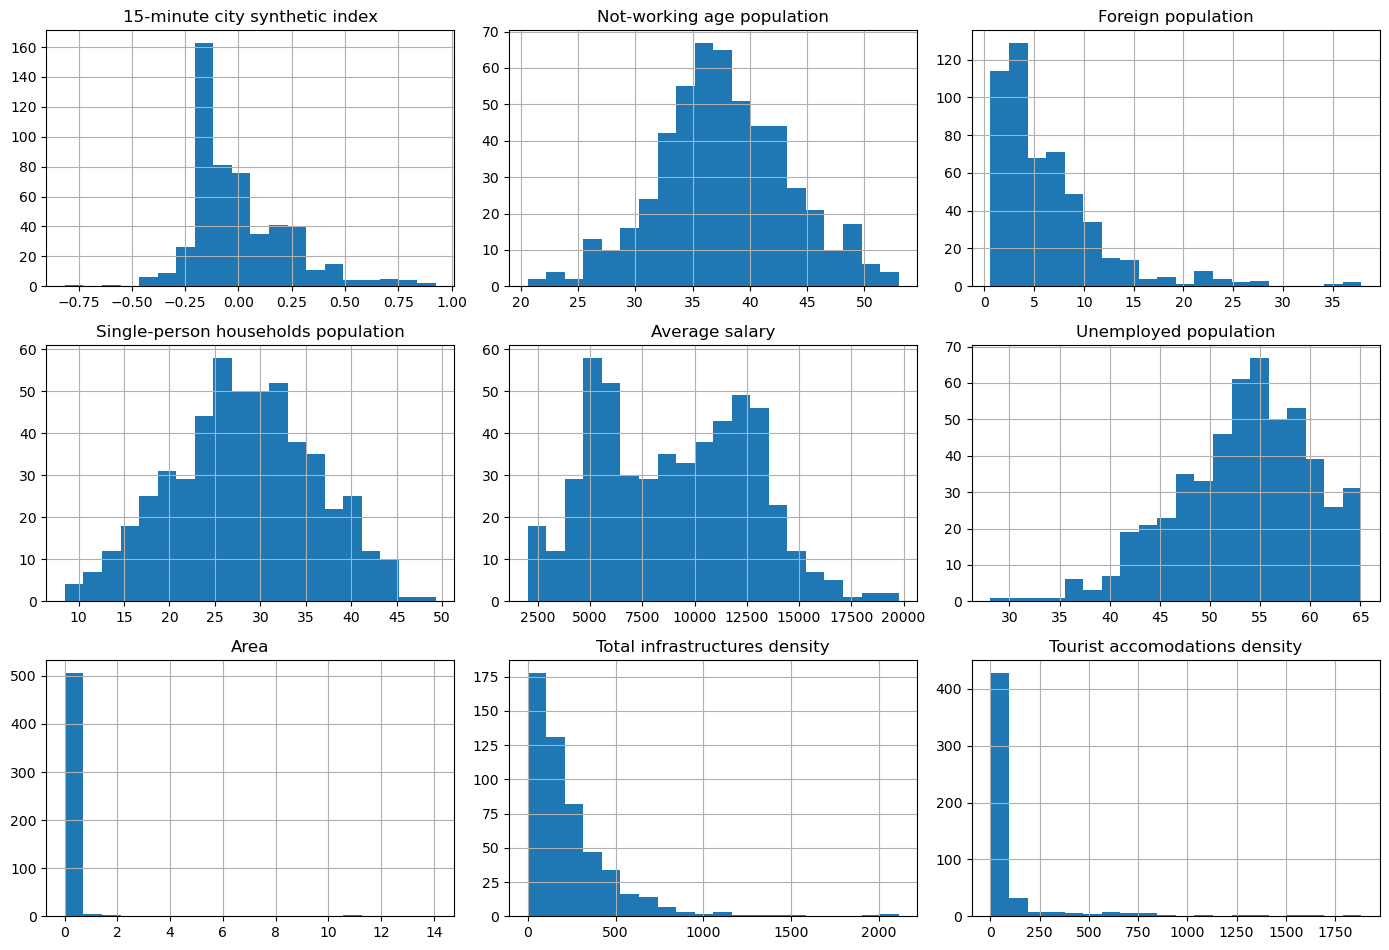

In [50]:
# Histogramas para cada variable
df.hist(bins=20, figsize=(14,10), layout=(3,3))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

C:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before o

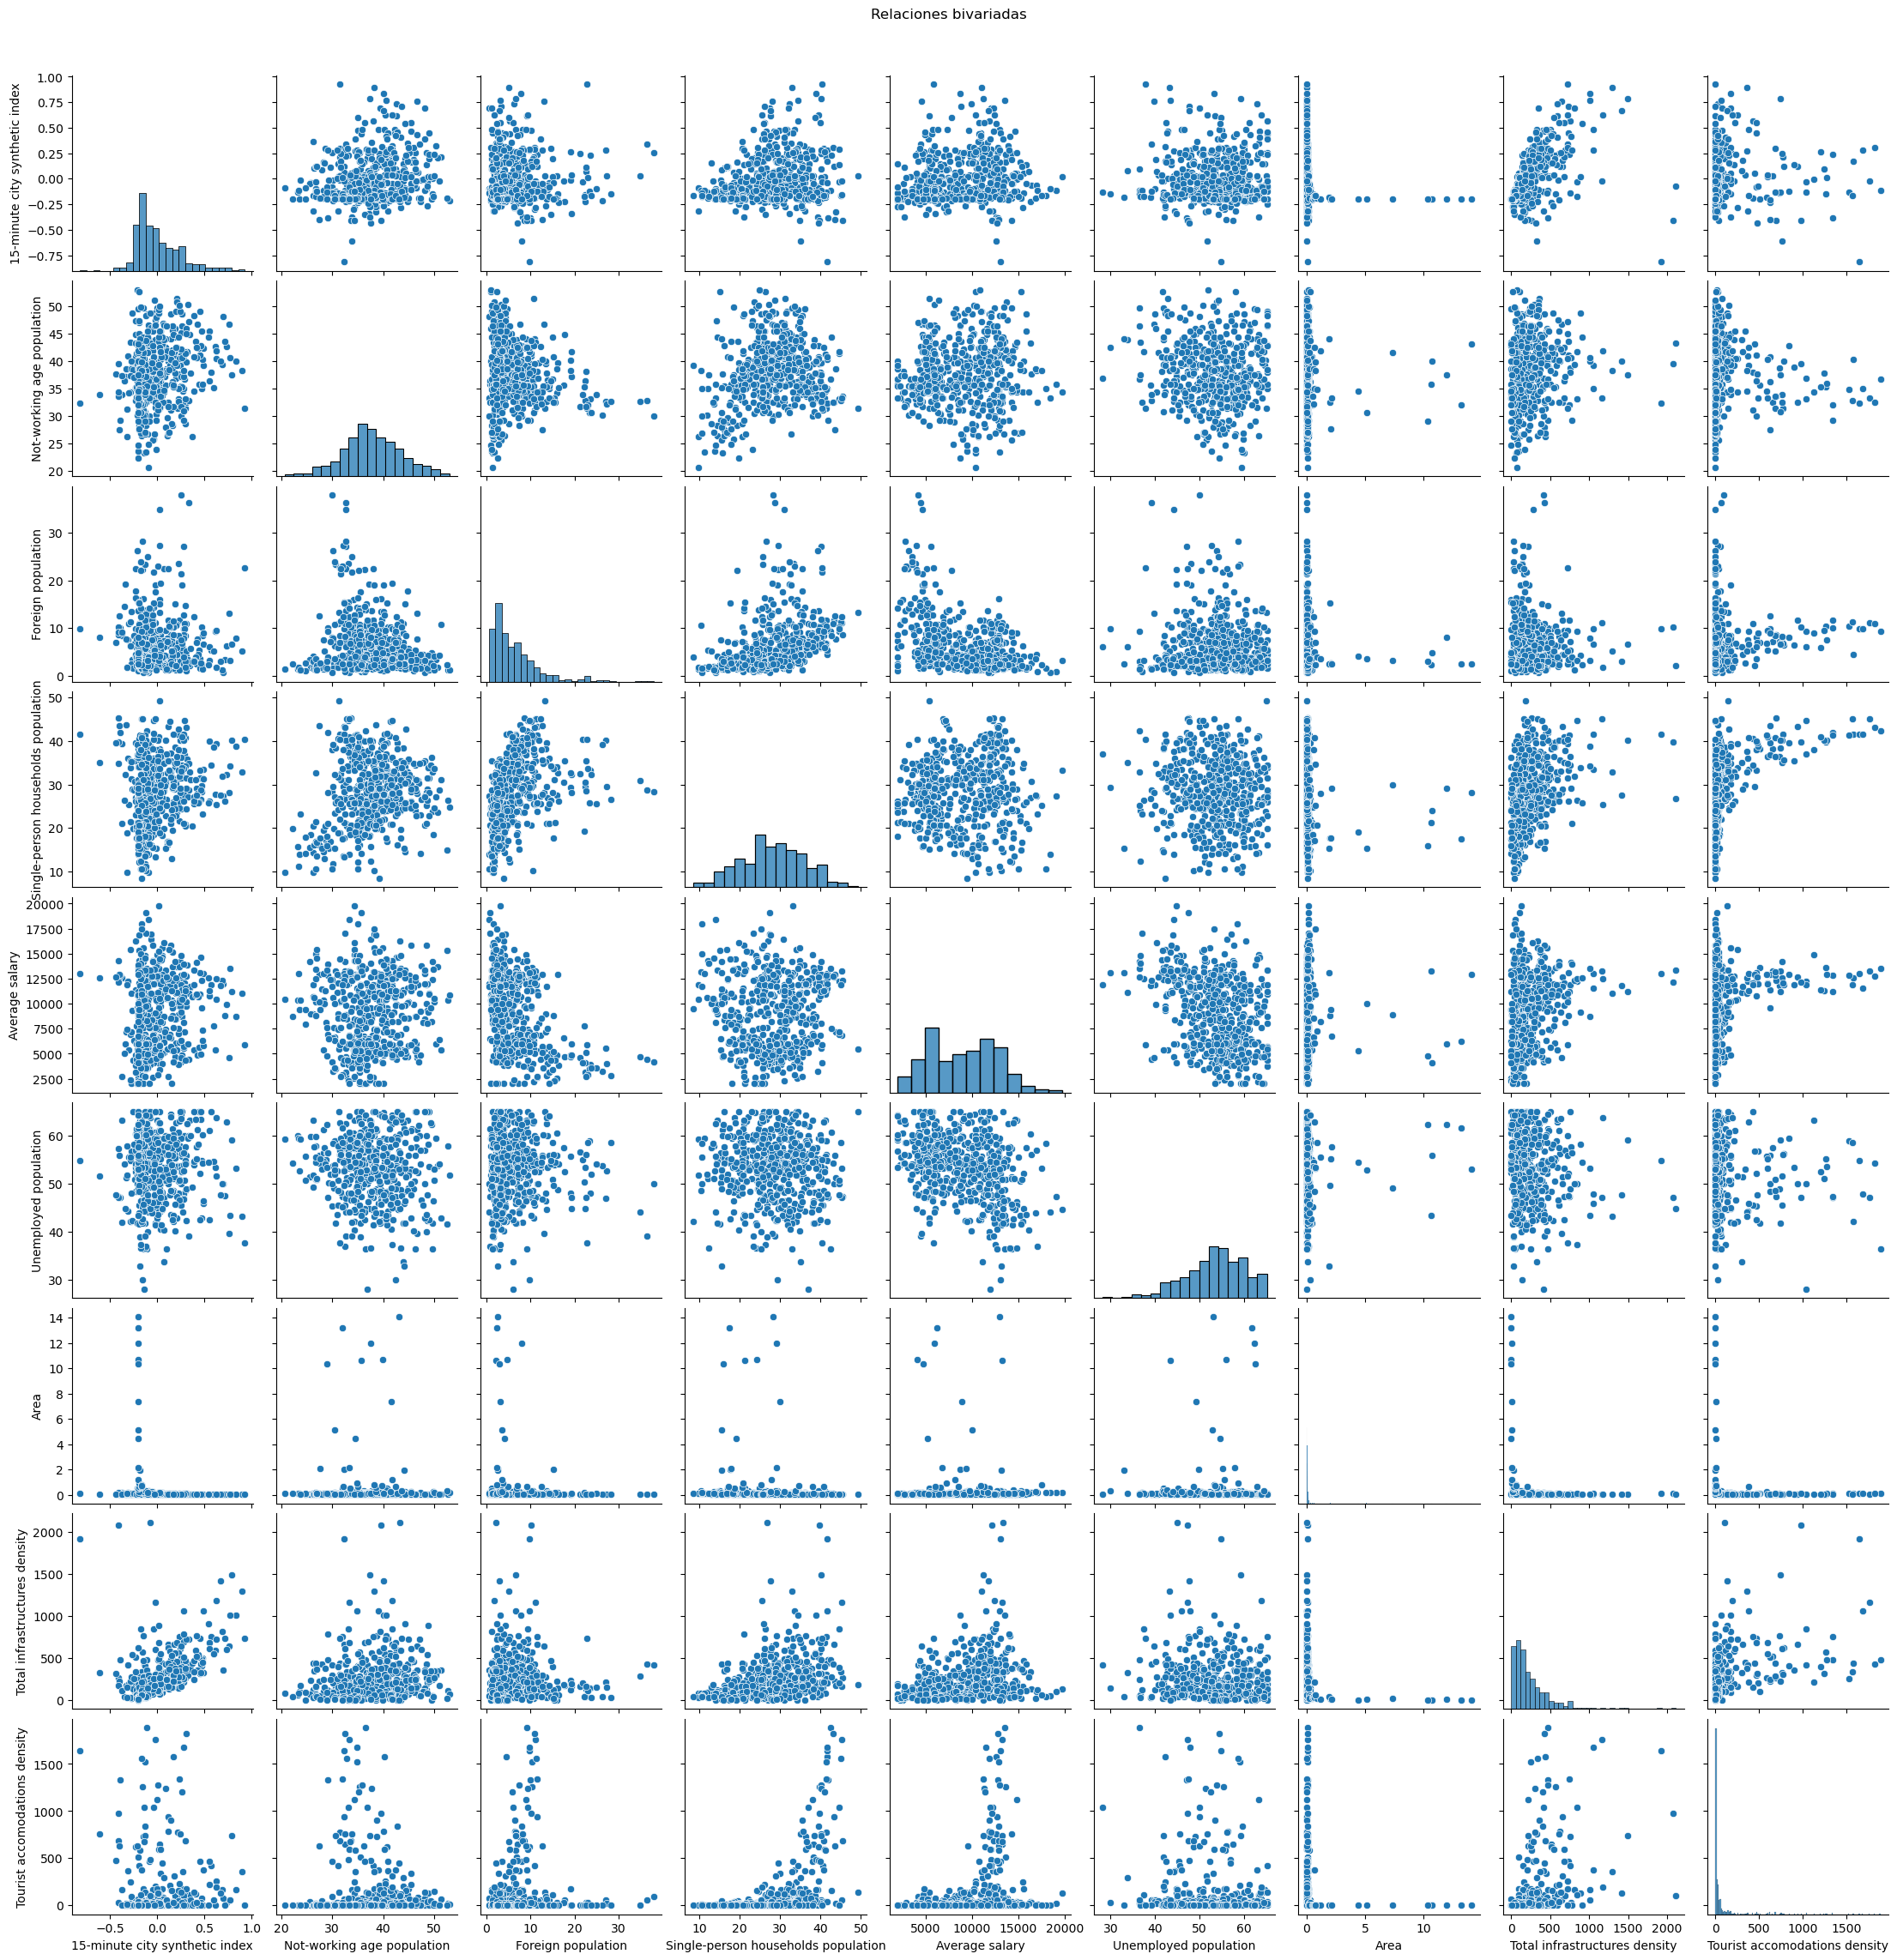

In [51]:
# Pares (scatterplots) para ver relaciones entre variables (puede tardar con muchas filas)
sns.pairplot(df)
plt.suptitle('Relaciones bivariadas', y=1.02)
plt.show()

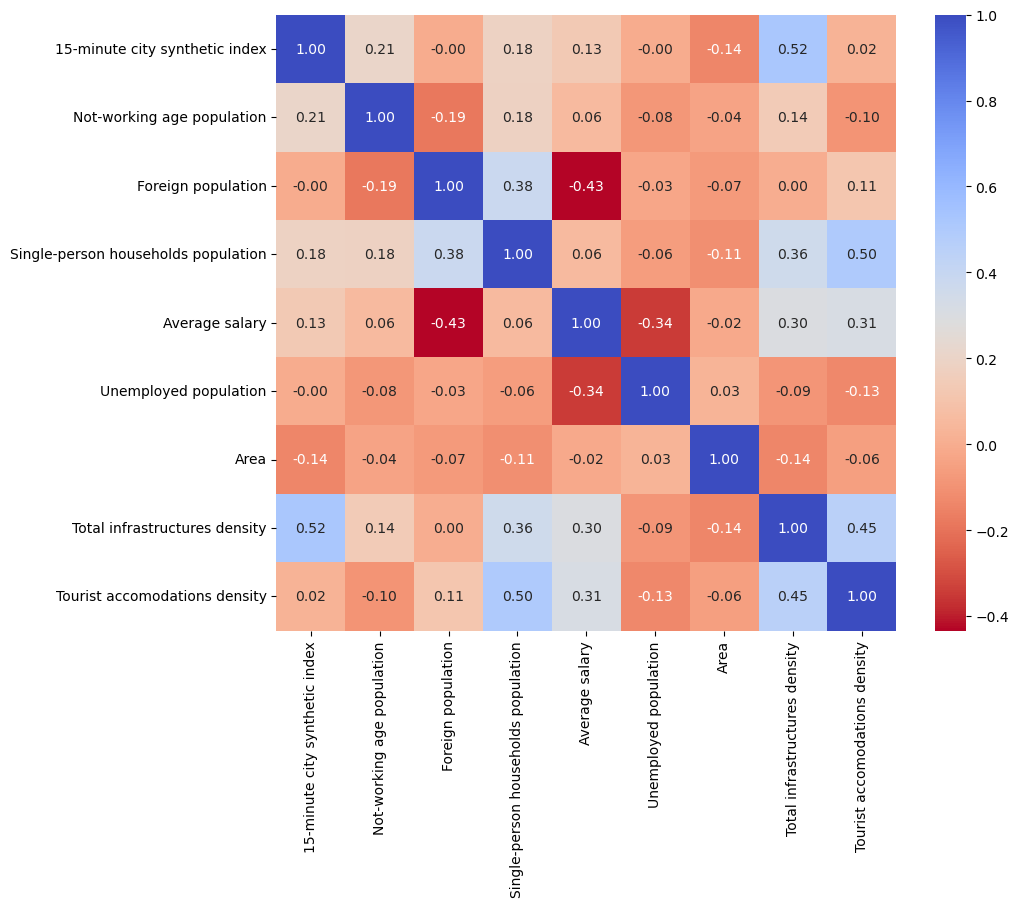

In [52]:
# Matriz de correlación con mapa de calor
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm_r', fmt=".2f")

plt.show()

In [53]:
# Interpretación correlación
umbral_alto = 0.75
print("\nRelaciones fuertes positivas (r > 0.75):")
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        val = corr.iloc[i,j]
        if val > umbral_alto:
            print(f" - {corr.columns[i]} y {corr.columns[j]}: r = {val:.3f}")

print("\nRelaciones fuertes negativas (r < -0.75):")
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        val = corr.iloc[i,j]
        if val < -umbral_alto:
            print(f" - {corr.columns[i]} y {corr.columns[j]}: r = {val:.3f}")


Relaciones fuertes positivas (r > 0.75):

Relaciones fuertes negativas (r < -0.75):


In [54]:
# Definir variables para regresión
y = data['indice_sin']
X = data[['por_no_lab', 'por_extran', 'por_unidim', 
          'salario', 'por_paro', 'area', 
          'densidad_c', 'densidad_a']]

# Añadir constante para OLS y modelos espaciales
X_const = sm.add_constant(X)  

# Estandarizar variables (restar media y dividir por desviación estándar)
X_std = (X - X.mean()) / X.std()
y_std = (y - y.mean()) / y.std()

# Matriz de pesos espaciales
w = Queen.from_dataframe(data)
w.transform = 'R'

C:\Users\Usuario\AppData\Local\Temp\ipykernel_27996\594553298.py:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(data)
C:\Users\Usuario\anaconda3\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


In [55]:
#Modelo OLS clásico
model_ols = sm.OLS(y, X_const).fit()
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:             indice_sin   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     35.37
Date:                Thu, 28 Aug 2025   Prob (F-statistic):           1.42e-44
Time:                        13:30:13   Log-Likelihood:                 136.08
No. Observations:                 524   AIC:                            -254.2
Df Residuals:                     515   BIC:                            -215.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4420      0.113     -3.899      0.0

In [57]:
residuos = model_ols.resid
predichos = model_ols.fittedvalues

# Extraer p-valores y coeficientes (excepto constante)
pvals = model_ols.pvalues.drop('const')
coeficientes = model_ols.params.drop('const')

print("\nInterpretación básica de coeficientes:")
for var in coeficientes.index:
    coef = coeficientes[var]
    pval = pvals[var]
    signo = "positivo" if coef > 0 else "negativo"
    signif = "significativo" if pval < 0.05 else "no significativo"
    print(f" - {var}: coeficiente {signo} ({coef:.4f}), {signif} (p={pval:.4f})")
    if pval < 0.05:
        sentido = "aumenta" if coef > 0 else "disminuye"
        print(f"   → La variable dependiente {sentido} en {abs(coef):.4f} unidades por cada unidad que aumenta '{var}'.")

# Cálculo VIF
X_vif = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data['variable'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

threshold = 5
print("\nAnálisis de multicolinealidad según VIF:")
for _, row in vif_data.iterrows():
    var = row['variable']
    vif = row['VIF']
    if vif > threshold:
        print(f" - {var} tiene VIF={vif:.2f} → Posible problema de multicolinealidad.")
    else:
        print(f" - {var} tiene VIF={vif:.2f} → No hay problema de multicolinealidad.")


Interpretación básica de coeficientes:
 - por_no_lab: coeficiente positivo (0.0033), significativo (p=0.0392)
   → La variable dependiente aumenta en 0.0033 unidades por cada unidad que aumenta 'por_no_lab'.
 - por_extran: coeficiente positivo (0.0018), no significativo (p=0.3798)
 - por_unidim: coeficiente positivo (0.0026), no significativo (p=0.0733)
 - salario: coeficiente positivo (0.0000), no significativo (p=0.1239)
 - por_paro: coeficiente positivo (0.0017), no significativo (p=0.2152)
 - area: coeficiente negativo (-0.0098), no significativo (p=0.1158)
 - densidad_c: coeficiente positivo (0.0005), significativo (p=0.0000)
   → La variable dependiente aumenta en 0.0005 unidades por cada unidad que aumenta 'densidad_c'.
 - densidad_a: coeficiente negativo (-0.0002), significativo (p=0.0000)
   → La variable dependiente disminuye en 0.0002 unidades por cada unidad que aumenta 'densidad_a'.

Análisis de multicolinealidad según VIF:
 - const tiene VIF=189.98 → Posible problema de 

In [58]:
# Interpretación básica R²
r2 = model_ols.rsquared
if r2 >= 0.75:
    print(f"\nR² = {r2:.3f}: El modelo explica gran parte de la variabilidad.")
elif r2 >= 0.5:
    print(f"\nR² = {r2:.3f}: El modelo explica una parte moderada.")
elif r2 >= 0.25:
    print(f"\nR² = {r2:.3f}: El modelo explica una parte baja.")
else:
    print(f"\nR² = {r2:.3f}: El modelo explica muy poca variabilidad.")
    
# Test-F global
f_stat = model_ols.fvalue
f_pvalue = model_ols.f_pvalue
print(f"Test-F global: estadístico = {f_stat:.3f}, p-valor = {f_pvalue:.4f}")
if f_pvalue < 0.05:
    print("El modelo es significativo globalmente (rechazamos H0).")
else:
    print("El modelo NO es significativo globalmente (no rechazamos H0).")

# Test Wald global (coeficientes distintos de cero)
import numpy as np
R = np.eye(len(model_ols.params))[1:]  # matriz de restricción sin constante
wald_test = model_ols.wald_test(R)
print(wald_test)
if wald_test.pvalue < 0.05:
    print("Test Wald: al menos uno de los coeficientes es significativamente distinto de cero.")
else:
    print("Test Wald: no se puede rechazar que todos los coeficientes sean cero.")
    
# Test Omnibus (normalidad conjunta)    
omnibus_stat, omni_pvalue = omni_normtest(residuos)
print(f"Test Omnibus: estadístico = {omnibus_stat:.3f}, p-valor = {omni_pvalue:.4f}")
if omni_pvalue < 0.05:
    print("Los residuos NO siguen una distribución normal (rechazamos normalidad).")
else:
    print("Los residuos siguen una distribución normal (no rechazamos normalidad).")
    
# Test Jarque-Bera (normalidad residuos)
jb_stat, jb_pvalue = jarque_bera(residuos)
print(f"Jarque-Bera test: estadístico={jb_stat:.3f}, p-valor={jb_pvalue:.3f}")
normalidad = jb_pvalue >= 0.05
print("Normalidad de residuos:", "Sí" if normalidad else "No")
    
# Test Koenker para heterocedasticidad (robusto a no normalidad)
bp_test = het_breuschpagan(residuos, model_ols.model.exog)
koenker_stat = bp_test[0] 
koenker_pvalue = bp_test[1]
print(f"Koenker test: estadístico={koenker_stat:.3f}, p-valor={koenker_pvalue:.3f}")
heterocedasticidad = koenker_pvalue >= 0.05
print("Heterocedasticidad:", "No detectada" if heterocedasticidad else "Detectada")

# Test Durbin-Watson (autocorrelación serial)
dw_stat = sm.stats.durbin_watson(residuos)
print(f"Durbin-Watson: estadístico = {dw_stat:.3f}")
if dw_stat < 1.5:
    print("Indicios de autocorrelación positiva en residuos.")
elif dw_stat > 2.5:
    print("Indicios de autocorrelación negativa en residuos.")
else:
    print("No hay indicios evidentes de autocorrelación serial en residuos.")
    
# Test Moran I (autocorrelación espacial)
mi = Moran(residuos, w)
print(f"Moran's I: {mi.I:.4f}")

if mi.p_norm < 0.05:
    print("Autocorrelación espacial significativa en los residuos.")
    autocorrelacion = False
else:
    print("No hay autocorrelación espacial significativa en los residuos.")
    autocorrelacion = True

# Evaluación global para decidir si hacer GWR
if normalidad and heterocedasticidad and autocorrelacion:
    print("\nCondiciones cumplidas para modelo OLS global.")
else:
    print("\nSe recomienda modelo GWR por violación de condiciones.")


R² = 0.355: El modelo explica una parte baja.
Test-F global: estadístico = 35.369, p-valor = 0.0000
El modelo es significativo globalmente (rechazamos H0).
<F test: F=array([[35.36927432]]), p=1.424656076859452e-44, df_denom=515, df_num=8>
Test Wald: al menos uno de los coeficientes es significativamente distinto de cero.
Test Omnibus: estadístico = 196.017, p-valor = 0.0000
Los residuos NO siguen una distribución normal (rechazamos normalidad).
Jarque-Bera test: estadístico=2622.765, p-valor=0.000
Normalidad de residuos: No
Koenker test: estadístico=201.990, p-valor=0.000
Heterocedasticidad: Detectada
Durbin-Watson: estadístico = 2.066
No hay indicios evidentes de autocorrelación serial en residuos.
Moran's I: 0.0864
Autocorrelación espacial significativa en los residuos.

Se recomienda modelo GWR por violación de condiciones.


C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\base\model.py:1906: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


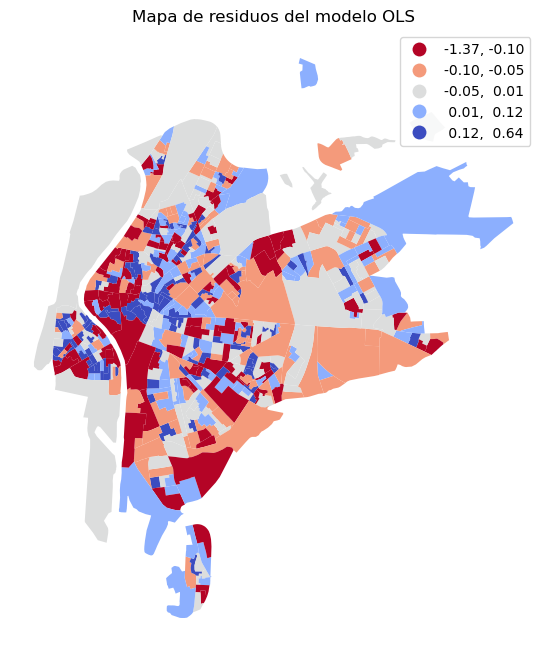

In [59]:
# Añadir residuos al GeoDataFrame
data['residuos_ols'] = residuos

# Mapa de residuos (puedes ajustar el cmap y esquema de colores)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
data.plot(column='residuos_ols', cmap='coolwarm_r', legend=True, scheme='quantiles', k=5, ax=ax)
ax.set_title('Mapa de residuos del modelo OLS')
ax.axis('off')
plt.show()

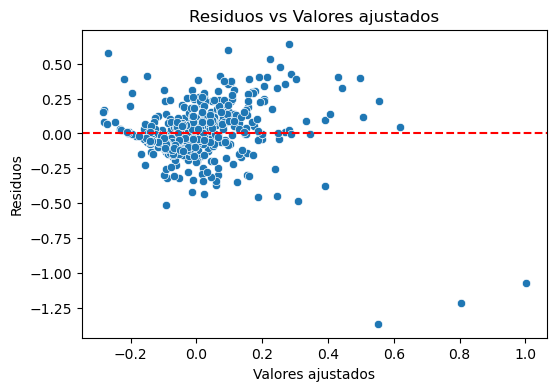

In [60]:
#Grafico de residuos

plt.figure(figsize=(6,4))
sns.scatterplot(x=predichos, y=residuos)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.title('Residuos vs Valores ajustados')
plt.show()

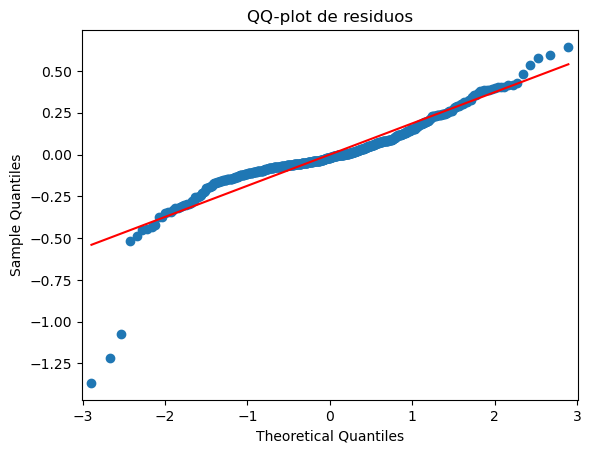

In [61]:
#QQ-plot (normalidad residuos)
sm.qqplot(residuos, line='s')
plt.title('QQ-plot de residuos')
plt.show()

C:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


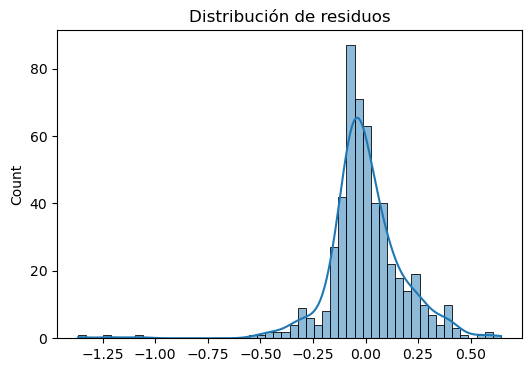

In [62]:
#Histograma residuos
plt.figure(figsize=(6,4))
sns.histplot(residuos, kde=True)
plt.title('Distribución de residuos')
plt.show()

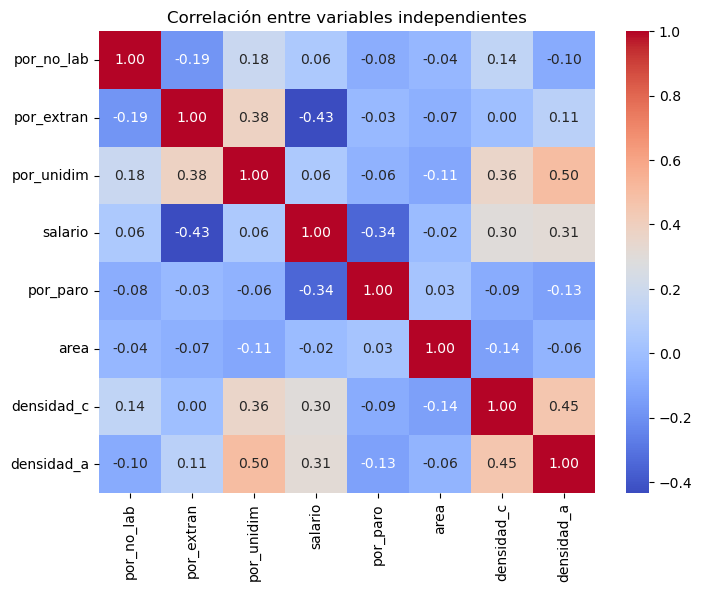

In [63]:
#Matriz de correlación de variables independientes
plt.figure(figsize=(8,6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlación entre variables independientes')
plt.show()

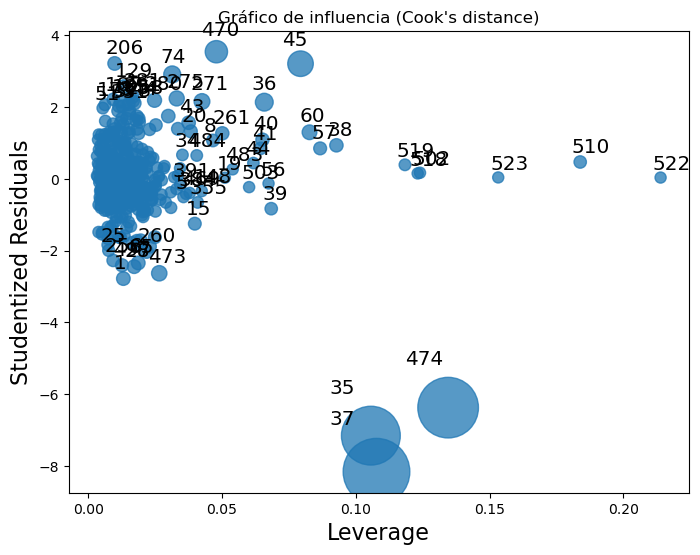

In [64]:
#Gráfico de influencia (outliers y leverage)
fig, ax = plt.subplots(figsize=(8,6))
sm.graphics.influence_plot(model_ols, ax=ax, criterion="cooks")
plt.title('Gráfico de influencia (Cook\'s distance)')
plt.show()

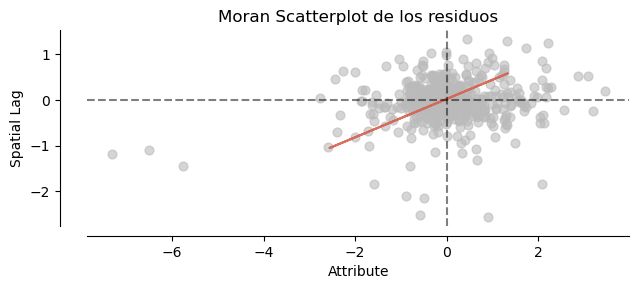

In [65]:
# Gráfico Moran Scatterplot
fig, ax = moran_scatterplot(mi)
ax.set_title("Moran Scatterplot de los residuos")
plt.show()

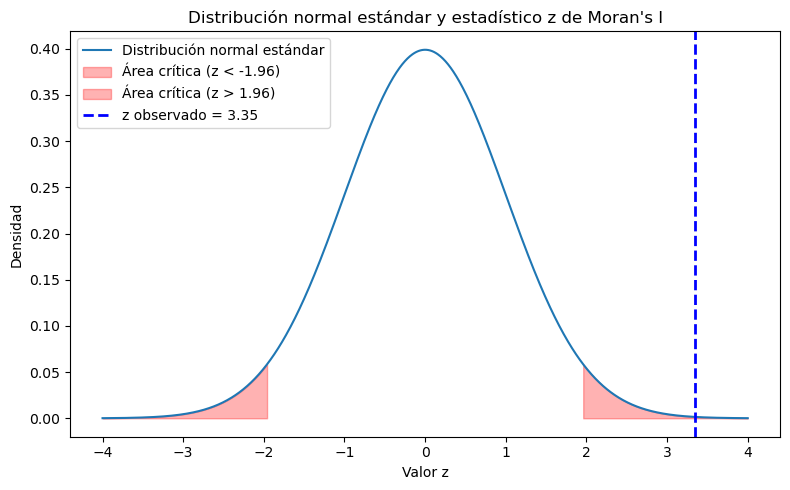

Los residuos están distribuidos espacialmente de forma dispersa (significativo).


In [66]:
#Valores z críticos para nivel 0.05 (bilateral)
z_crit_pos = norm.ppf(0.975)  # ~1.96
z_crit_neg = norm.ppf(0.025)  # ~-1.96

# Estadístico z de Moran (z-score)
z_moran = mi.z_norm

# p-valor de Moran ya lo tienes: mi.p_norm

# Crear valores para la campana normal estándar
x = np.linspace(-4, 4, 1000)
y = norm.pdf(x, 0, 1)

plt.figure(figsize=(8,5))
plt.plot(x, y, label='Distribución normal estándar')

# Rellenar área crítica izquierda
x_fill_left = np.linspace(-4, z_crit_neg, 100)
plt.fill_between(x_fill_left, 0, norm.pdf(x_fill_left), color='red', alpha=0.3, label='Área crítica (z < {:.2f})'.format(z_crit_neg))

# Rellenar área crítica derecha
x_fill_right = np.linspace(z_crit_pos, 4, 100)
plt.fill_between(x_fill_right, 0, norm.pdf(x_fill_right), color='red', alpha=0.3, label='Área crítica (z > {:.2f})'.format(z_crit_pos))

# Marcar el valor observado de z_moran
plt.axvline(z_moran, color='blue', linestyle='--', linewidth=2, label=f'z observado = {z_moran:.2f}')

plt.title("Distribución normal estándar y estadístico z de Moran's I")
plt.xlabel('Valor z')
plt.ylabel('Densidad')
plt.legend()

plt.tight_layout()
plt.show()

# Mensaje según nivel de significancia
alpha = 0.1
if mi.p_norm > alpha:
    mensaje = "Los residuos están distribuidos espacialmente en forma de clúster (no significativo)."
elif mi.p_norm < alpha:
    mensaje = "Los residuos están distribuidos espacialmente de forma dispersa (significativo)."
else:
    mensaje = "Los residuos están distribuidos espacialmente de forma aleatoria."

print(mensaje)

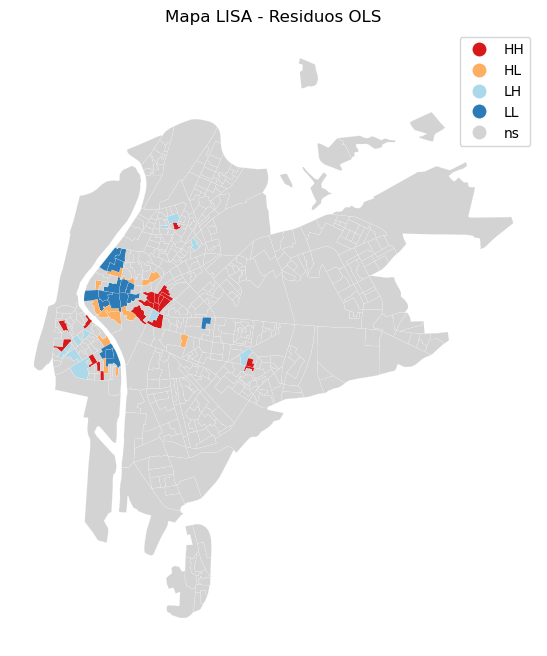

In [67]:
# --- LISA (Local Moran's I) ---
lisa = Moran_Local(residuos, w)

# Añadimos resultados al GeoDataFrame
data["lisa_cluster"] = lisa.q
data["lisa_pvalue"] = lisa.p_sim

# --- Mapa LISA ---
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
lisa_cluster(lisa, data, p=0.05, ax=ax)  # Solo muestra clusters significativos (p<0.05)
ax.set_title("Mapa LISA - Residuos OLS")
plt.show()

# Interpretación de lisa.q:
# 1 = HH (alta con alta) (Clúster positivo (hot spot))
# 2 = LH (baja con alta) (Valor atípico (low surrounded by high))
# 3 = LL (baja con baja) (Clúster positivo (cold spot))
# 4 = HL (alta con baja) (Valor atípico (high surrounded by low))
# 5 = ns (no significativo) ((sin evidencia de patrón espacial local))

In [68]:
#Modelo GWR (Geographically Weighted Regression)

if data.crs.is_geographic:
    print("Advertencia: reproyectando a CRS proyectado para centroides")
    data = data.to_crs(epsg=3857)

In [69]:
# Filtrar filas sin valores nulos en variables de interés y geometría
variables_cols = ['indice_sin', 'por_no_lab', 'por_extran', 'por_unidim', 
                  'salario', 'gini', 'area', 
                  'densidad_c', 'densidad_a']


data_sub = data[variables_cols + ['geometry']].dropna()

# Coordenadas
coords = np.column_stack([
    data_sub.geometry.centroid.x, 
    data_sub.geometry.centroid.y
])

# Variable dependiente y matriz de independientes
y_array = data_sub['indice_sin'].values.reshape((-1, 1))
X_raw = data_sub[variables_cols[1:]].values

# --- Estandarización Z ---
scaler = StandardScaler()
X_array = scaler.fit_transform(X_raw)

# Selección de ancho de banda óptimo
selector = Sel_BW(coords, y_array, X_array)
bw = selector.search(bw_min=2)
print(f"\nAncho de banda óptimo para GWR: {bw}")

# Ajuste del modelo
gwr_model = GWR(coords, y_array, X_array, bw)
gwr_results = gwr_model.fit()
print(gwr_results.summary())

# Guardar coeficientes locales en la tabla
for i, var in enumerate(variables_cols[1:]):
    data_sub[f'gwr_coef_{var}'] = gwr_results.params[:, i]

# Calcular residuos (observado - predicho)
data_sub['residuos'] = y_array.flatten() - gwr_results.predy.flatten()


Ancho de banda óptimo para GWR: 197.0
Model type                                                         Gaussian
Number of observations:                                                 524
Number of covariates:                                                     9

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             17.995
Log-likelihood:                                                     139.779
AIC:                                                               -261.559
AICc:                                                              -259.130
BIC:                                                              -3206.673
R2:                                                                   0.364
Adj. R2:                                                              0.354

Variable                              Est.         SE  t(Est/SE)    p-value
---------------------

In [70]:
# Coeficientes medios y p-valores medios
print(f"{'Variable':15s} {'Coef. medio':>12s} {'p-valor medio':>15s}")
for i, var in enumerate(variables[0:]):  # quitar constante
    coef_mean = gwr_results.params[:, i].mean()
    pval_mean = gwr_results.filter_tvals()[:, i].mean()  # OJO: depende de cómo exportes p-valores
    signo = "positivo" if coef_mean > 0 else "negativo"
    print(f"{var:15s} {coef_mean:12.4f} {pval_mean:15.4f} → {signo}")

Variable         Coef. medio   p-valor medio
indice_sin            0.0365          0.6953 → positivo
por_no_lab            0.0053          0.0000 → positivo
por_extran            0.0189          0.0050 → positivo
por_unidim           -0.0023          0.0000 → negativo
salario              -0.0152         -0.3462 → negativo
por_paro             -0.0337         -0.2444 → negativo
area                 -0.1123         -0.6309 → negativo
densidad_c            0.2081          7.6073 → positivo
densidad_a           -0.0642         -0.7649 → negativo


In [71]:
residuos_gwr = gwr_results.resid_response

t_stats = gwr_results.params / gwr_results.bse
p_vals = 2 * (1 - norm.cdf(np.abs(t_stats))) 

alpha = 0.05
n = len(data_sub)          
k = X_array.shape[1]       
alpha_adj = alpha / k      
t_crit_adj = t.ppf(1 - alpha_adj/2, df=n - k - 1)

# Crear GeoDataFrames para coeficientes, p-valores y t-estadísticos
coef_gdfs = {}
for i, var in enumerate(variables):   # NO variables[1:]
    data_sub[f'gwr_coef_{var}'] = gwr_results.params[:, i]
    data_sub[f'gwr_pval_{var}'] = p_vals[:, i]
    data_sub[f'gwr_tstat_{var}'] = t_stats[:, i]
    
    coef_gdfs[var] = data_sub[[f'gwr_coef_{var}', 'geometry']].copy()
    
print("=== Resumen GWR con criterio ajustado y p-valor medio de coeficientes ===")
for var in variables[1:]:
    coef_col = f'gwr_coef_{var}'
    pval_col = f'gwr_pval_{var}'
    tstat_col = f'gwr_tstat_{var}'

    missing = [col for col in [coef_col, pval_col, tstat_col] if col not in data_sub.columns]
    if missing:
        print(f"\n¡Atención! No existen las columnas: {missing}. Saltando variable '{var}'.")
        continue

    coefs = data_sub[coef_col]
    pvals_local = data_sub[pval_col]
    tstats_local = data_sub[tstat_col]

    # Criterio ajustado de significancia
    sig_points = ((pvals_local < alpha_adj) & (np.abs(tstats_local) > t_crit_adj)).sum()
    total_points = len(data_sub)
    perc_sig = sig_points / total_points * 100

    # Estadísticas de coeficientes y t
    mean_coef = coefs.mean()
    min_coef = coefs.min()
    max_coef = coefs.max()

    mean_t = tstats_local.mean()
    min_t = tstats_local.min()
    max_t = tstats_local.max()

    # --- NUEVO: p-valor medio de los coeficientes ---
    mean_pval = pvals_local.mean()

    # Impresión del resumen
    print(f"\nVariable '{var}':")
    print(f"  - Coeficiente medio: {mean_coef:.4f}")
    print(f"  - Rango coeficiente: [{min_coef:.4f}, {max_coef:.4f}]")
    print(f"  - t medio: {mean_t:.3f}, rango t: [{min_t:.3f}, {max_t:.3f}]")
    print(f"  - p-valor medio: {mean_pval:.4f}")
    print(f"  - Observaciones con p < {alpha_adj:.4f} y |t| > {t_crit_adj:.3f}: "
          f"{sig_points} de {total_points} ({perc_sig:.1f}%)")

    if perc_sig > 50:
        print(f"  → '{var}' es significativa localmente en la mayoría de lugares (criterio ajustado).")
    elif perc_sig > 10:
        print(f"  → '{var}' es significativa localmente en algunas zonas (criterio ajustado).")
    else:
        print(f"  → '{var}' rara vez es significativa localmente (criterio ajustado).")

    print(f"  → El coeficiente varía espacialmente mostrando heterogeneidad en el efecto.")

=== Resumen GWR con criterio ajustado y p-valor medio de coeficientes ===

Variable 'por_no_lab':
  - Coeficiente medio: 0.0053
  - Rango coeficiente: [-0.0362, 0.0319]
  - t medio: 0.297, rango t: [-1.465, 1.445]
  - p-valor medio: 0.5945
  - Observaciones con p < 0.0063 y |t| > 2.746: 0 de 524 (0.0%)
  → 'por_no_lab' rara vez es significativa localmente (criterio ajustado).
  → El coeficiente varía espacialmente mostrando heterogeneidad en el efecto.

Variable 'por_extran':
  - Coeficiente medio: 0.0189
  - Rango coeficiente: [-0.1289, 0.0878]
  - t medio: 0.804, rango t: [-2.835, 2.814]
  - p-valor medio: 0.4089
  - Observaciones con p < 0.0063 y |t| > 2.746: 4 de 524 (0.8%)
  → 'por_extran' rara vez es significativa localmente (criterio ajustado).
  → El coeficiente varía espacialmente mostrando heterogeneidad en el efecto.

Variable 'por_unidim':
  - Coeficiente medio: -0.0023
  - Rango coeficiente: [-0.0753, 0.0538]
  - t medio: -0.034, rango t: [-2.481, 1.514]
  - p-valor medio:

In [72]:
# Multicolinealidad
X_vif = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data['variable'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

threshold = 5
print("\nAnálisis de multicolinealidad según VIF (GWR):")
for _, row in vif_data.iterrows():
    var = row['variable']
    vif = row['VIF']
    if vif > threshold:
        print(f" - {var} tiene VIF={vif:.2f} → Posible problema de multicolinealidad.")
    else:
        print(f" - {var} tiene VIF={vif:.2f} → No hay problema de multicolinealidad.")


Análisis de multicolinealidad según VIF (GWR):
 - const tiene VIF=189.98 → Posible problema de multicolinealidad.
 - por_no_lab tiene VIF=1.26 → No hay problema de multicolinealidad.
 - por_extran tiene VIF=1.80 → No hay problema de multicolinealidad.
 - por_unidim tiene VIF=1.86 → No hay problema de multicolinealidad.
 - salario tiene VIF=1.80 → No hay problema de multicolinealidad.
 - por_paro tiene VIF=1.22 → No hay problema de multicolinealidad.
 - area tiene VIF=1.03 → No hay problema de multicolinealidad.
 - densidad_c tiene VIF=1.41 → No hay problema de multicolinealidad.
 - densidad_a tiene VIF=1.75 → No hay problema de multicolinealidad.


In [73]:
def plot_gwr_maps(var, coef_gdfs, data_sub, alpha_adj, t_crit_adj):
    coef_col = f'gwr_coef_{var}'
    pval_col = f'gwr_pval_{var}'
    tstat_col = f'gwr_tstat_{var}'
    
    required_cols = [coef_col, pval_col, tstat_col]
    missing = [col for col in required_cols if col not in data_sub.columns]
    if missing:
        raise KeyError(
            f"No se pueden generar los mapas. Faltan las columnas: {missing}. "
            "Asegúrate de haber calculado los coeficientes, p-valores y t-estadísticos antes."
        )
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Mapa de coeficientes
    coef_gdfs[var].plot(column=coef_col, cmap='coolwarm_r', legend=True, ax=axes[0])
    axes[0].set_title(f"Coeficientes locales GWR para '{var}'")

    # Mapa de significancia ajustada
    sig_mask = (data_sub[pval_col] < alpha_adj) & (np.abs(data_sub[tstat_col]) > t_crit_adj)
    data_sub.assign(significant=sig_mask).plot(
        column='significant', cmap='coolwarm_r', legend=True, ax=axes[1]
    )
    axes[1].set_title(
        f"Significancia local ajustada\n(p < {alpha_adj:.4f}, |t| > {t_crit_adj:.2f})"
    )

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

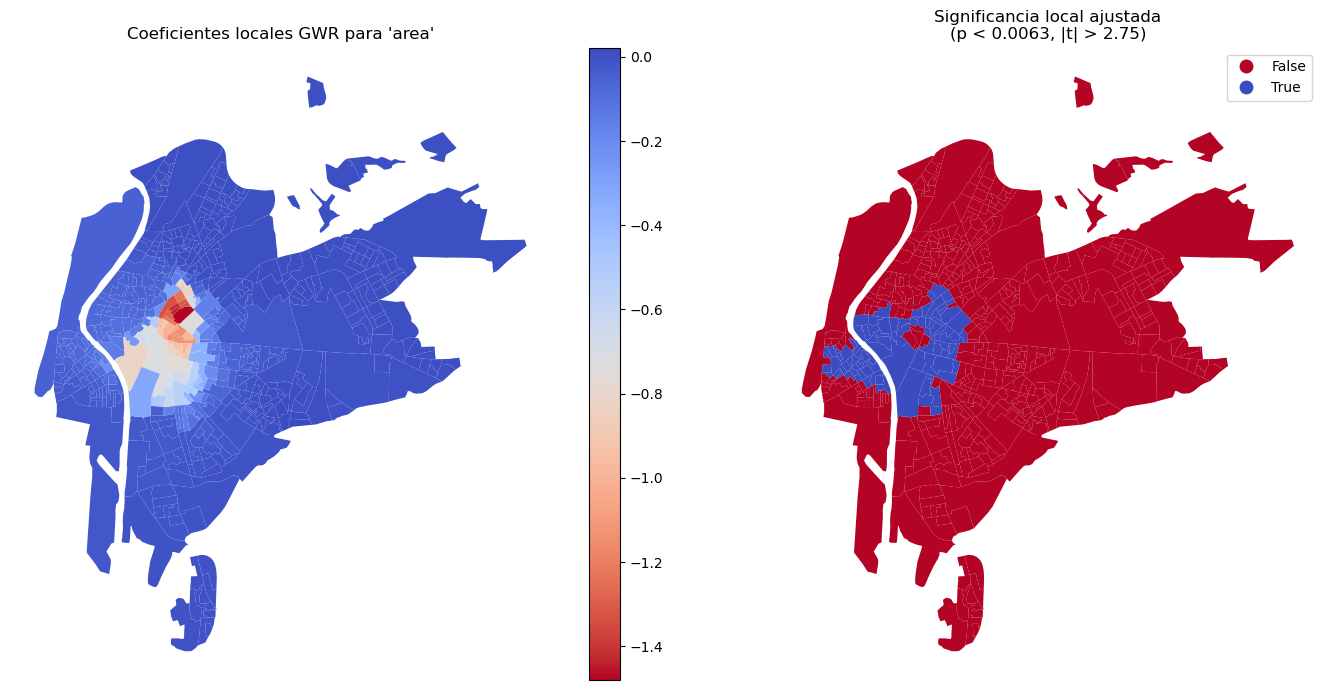

In [74]:
#variables_cols = ['indice_sin', 'por_no_lab', 'por_extran', 'por_unidim', 'salario', 'por_paro', 'area', 'densidad_c', 'densidad_a']
        
plot_gwr_maps("area", coef_gdfs, data_sub, alpha_adj, t_crit_adj)


In [121]:
r2_adj = gwr_results.R2
if r2_adj >= 0.75:
    print(f"\nR² ajustado = {r2_adj:.3f}: El modelo GWR explica gran parte de la variabilidad local.")
elif r2_adj >= 0.5:
    print(f"\nR² ajustado = {r2_adj:.3f}: El modelo GWR explica una parte moderada de la variabilidad local.")
elif r2_adj >= 0.25:
    print(f"\nR² ajustado = {r2_adj:.3f}: El modelo GWR explica una parte baja de la variabilidad local.")
else:
    print(f"\nR² ajustado = {r2_adj:.3f}: El modelo GWR explica muy poca variabilidad local.")
    
# Omnibus (D’Agostino y Pearson)
omnibus_stat, omni_pvalue = normaltest(residuos_gwr)
print(f"Test Omnibus: estadístico = {omnibus_stat:.3f}, p-valor = {omni_pvalue:.4f}")
if omni_pvalue < 0.05:
    print("Los residuos NO siguen una distribución normal (rechazamos normalidad).")
else:
    print("Los residuos siguen una distribución normal (no rechazamos normalidad).")

# Jarque-Bera
jb_result = jarque_bera(residuos_gwr)
jb_stat, jb_pvalue = jb_result[0], jb_result[1]
print(f"Jarque-Bera: estadístico = {jb_stat:.3f}, p-valor = {jb_pvalue:.4f}")
normalidad = jb_pvalue >= 0.05
print("Normalidad de residuos:", "Sí" if normalidad else "No")

# Shapiro-Wilk
shapiro_stat, shapiro_p = shapiro(residuos_gwr)
print(f"Shapiro-Wilk: estadístico = {shapiro_stat:.3f}, p-valor = {shapiro_p:.4f}")

# Heterocedasticidad
X_bp = sm.add_constant(X, has_constant='add')
bp_test = het_breuschpagan(residuos_gwr, X_bp)
koenker_stat = bp_test[0] 
koenker_pvalue = bp_test[1]

print(f"Koenker test: estadístico={koenker_stat:.3f}, p-valor={koenker_pvalue:.3f}")
heterocedasticidad = koenker_pvalue >= 0.05
print("Heterocedasticidad:", "No detectada" if heterocedasticidad else "Detectada")

# Autocorrelación serial (Durbin-Watson global)
dw_stat = sm.stats.durbin_watson(residuos_gwr)
print(f"Durbin-Watson: estadístico = {dw_stat:.3f}")
if dw_stat < 1.5:
    print("Indicios de autocorrelación positiva en residuos.")
elif dw_stat > 2.5:
    print("Indicios de autocorrelación negativa en residuos.")
else:
    print("No hay indicios evidentes de autocorrelación serial en residuos.")

# Autocorrelación espacial (Moran's I)
mi = Moran(residuos_gwr, w)  # w = matriz de pesos espaciales
print(f"Moran's I: {mi.I:.4f}")
if mi.p_norm < 0.05:
    print("Autocorrelación espacial significativa en los residuos.")
    autocorrelacion = False
else:
    print("No hay autocorrelación espacial significativa en los residuos.")
    autocorrelacion = True


R² ajustado = 0.555: El modelo GWR explica una parte moderada de la variabilidad local.
Test Omnibus: estadístico = 50.722, p-valor = 0.0000
Los residuos NO siguen una distribución normal (rechazamos normalidad).
Jarque-Bera: estadístico = 235.701, p-valor = 0.0000
Normalidad de residuos: No
Shapiro-Wilk: estadístico = 0.939, p-valor = 0.0000
Koenker test: estadístico=225.636, p-valor=0.000
Heterocedasticidad: Detectada
Durbin-Watson: estadístico = 2.111
No hay indicios evidentes de autocorrelación serial en residuos.
Moran's I: 0.0186
No hay autocorrelación espacial significativa en los residuos.


Shapiro-Wilk: ShapiroResult(statistic=0.939099907875061, pvalue=8.149093243736347e-14)


C:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


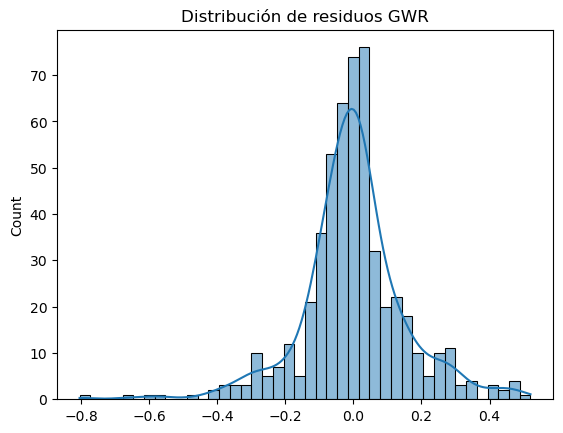

In [122]:
# Residuos locales
residuos_gwr = gwr_results.resid_response.flatten()

# Test de normalidad global sobre todos los residuos
shapiro_test = stats.shapiro(residuos_gwr)
print("Shapiro-Wilk:", shapiro_test)

# Distribución visual
sns.histplot(residuos_gwr, kde=True)
plt.title("Distribución de residuos GWR")
plt.show()

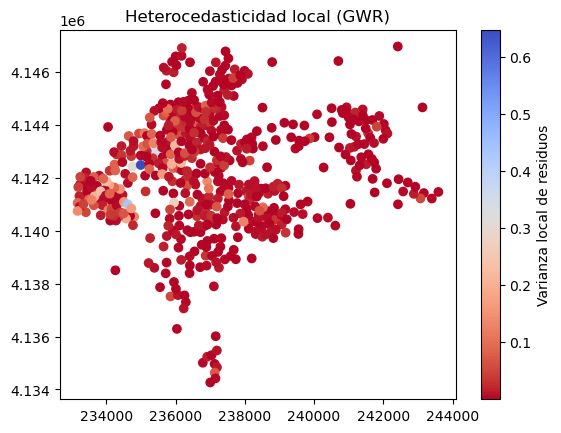

ValueError: The Breusch-Pagan test requires exog to have at least two columns where one is a constant.

In [123]:
# Varianza local de residuos
var_local = residuos_gwr**2
plt.scatter(coords[:,0], coords[:,1], c=var_local, cmap='coolwarm_r')
plt.colorbar(label="Varianza local de residuos")
plt.title("Heterocedasticidad local (GWR)")
plt.show()

# Breusch-Pagan global sobre GWR
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(residuos_gwr, X)
print("Breusch-Pagan:", bp_test)

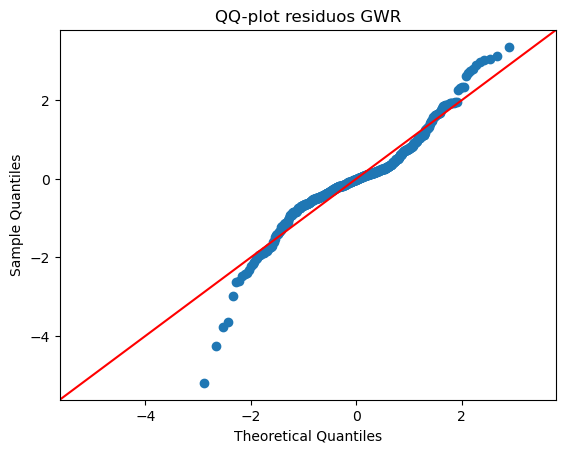

In [124]:
sm.qqplot(residuos_gwr, line='45', fit=True)
plt.title("QQ-plot residuos GWR")
plt.show()

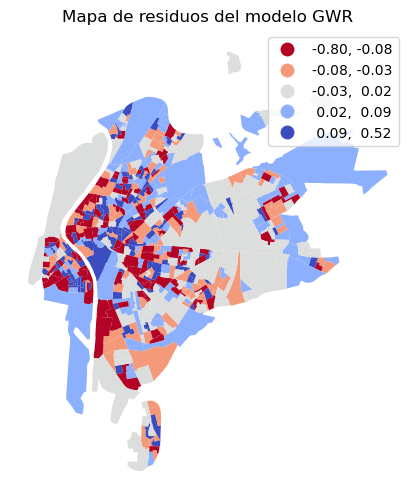

In [125]:
data['residuos_gwr'] = residuos_gwr

#  Mapa de residuos
fig, ax = plt.subplots(figsize=(8,6))
data.plot(column='residuos_gwr', cmap='coolwarm_r', legend=True, scheme='quantiles', k=5, ax=ax)
ax.set_title("Mapa de residuos del modelo GWR")
ax.axis('off')
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_28484\3044422002.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(data_sub)
C:\Users\Usuario\anaconda3\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


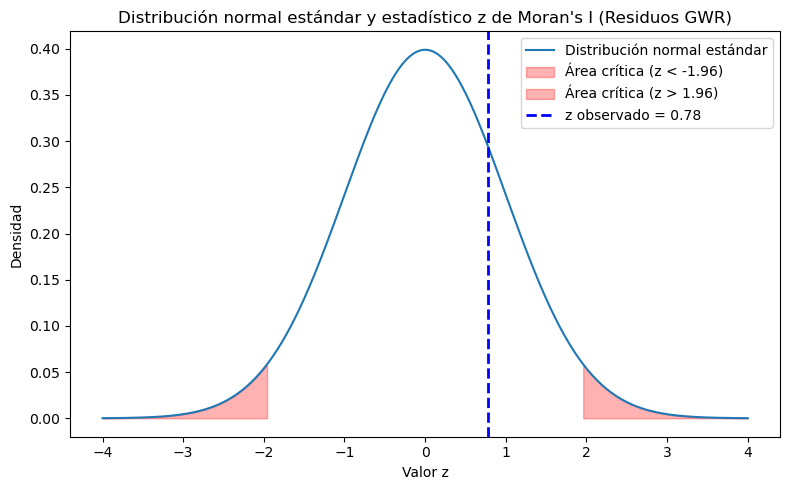

Los residuos GWR están distribuidos espacialmente en forma de clúster (no significativo).


In [126]:
# --- Matriz de pesos espaciales ---
w = libpysal.weights.Queen.from_dataframe(data_sub)
w.transform = 'r'  # row-standardized

# --- Calcular Moran's I de residuos GWR ---
residuos_gwr = gwr_results.resid_response
mi_gwr = Moran(residuos_gwr, w)

# Valores z críticos para nivel 0.05 (bilateral)
z_crit_pos = norm.ppf(0.975)  # ~1.96
z_crit_neg = norm.ppf(0.025)  # ~-1.96

# Estadístico z de Moran (z-score) para residuos GWR
z_moran_gwr = mi_gwr.z_norm

# p-valor de Moran para residuos GWR
pval_moran_gwr = mi_gwr.p_norm

# Crear valores para la campana normal estándar
x = np.linspace(-4, 4, 1000)
y = norm.pdf(x, 0, 1)

plt.figure(figsize=(8,5))
plt.plot(x, y, label='Distribución normal estándar')

# Rellenar área crítica izquierda
x_fill_left = np.linspace(-4, z_crit_neg, 100)
plt.fill_between(x_fill_left, 0, norm.pdf(x_fill_left), color='red', alpha=0.3, label=f'Área crítica (z < {z_crit_neg:.2f})')

# Rellenar área crítica derecha
x_fill_right = np.linspace(z_crit_pos, 4, 100)
plt.fill_between(x_fill_right, 0, norm.pdf(x_fill_right), color='red', alpha=0.3, label=f'Área crítica (z > {z_crit_pos:.2f})')

# Marcar el valor observado de z_moran_gwr
plt.axvline(z_moran_gwr, color='blue', linestyle='--', linewidth=2, label=f'z observado = {z_moran_gwr:.2f}')

plt.title("Distribución normal estándar y estadístico z de Moran's I (Residuos GWR)")
plt.xlabel('Valor z')
plt.ylabel('Densidad')
plt.legend()

plt.tight_layout()
plt.show()

# Mensaje según nivel de significancia
alpha = 0.1
if pval_moran_gwr > alpha:
    mensaje = "Los residuos GWR están distribuidos espacialmente en forma de clúster (no significativo)."
elif pval_moran_gwr < alpha:
    mensaje = "Los residuos GWR están distribuidos espacialmente de forma dispersa (significativo)."
else:
    mensaje = "Los residuos GWR están distribuidos espacialmente de forma aleatoria."

print(mensaje)

In [127]:
print("=== Comparación de coeficientes entre OLS y GWR ===\n")

var_names = X.columns.tolist()

# Coeficientes OLS (sin constante)
coef_ols = model_ols.params.drop('const')

# Coeficientes GWR: calculamos media y rango (min-max) por variable
coef_gwr_means = gwr_results.params.mean(axis=0)
coef_gwr_min = gwr_results.params.min(axis=0)
coef_gwr_max = gwr_results.params.max(axis=0)

for i, var in enumerate(var_names):
    ols_coef = coef_ols[var]
    gwr_mean = coef_gwr_means[i]
    gwr_min = coef_gwr_min[i]
    gwr_max = coef_gwr_max[i]

    print(f"Variable '{var}':")
    print(f"  - Coeficiente OLS global: {ols_coef:.4f} ({'positivo' if ols_coef > 0 else 'negativo'})")
    print(f"  - Coeficiente GWR promedio: {gwr_mean:.4f} (rango: {gwr_min:.4f} a {gwr_max:.4f})")

    # Interpretación signo y rango
    if np.sign(ols_coef) == np.sign(gwr_mean):
        print(f"  → El signo del coeficiente es consistente entre OLS y GWR.")
    else:
        print(f"  → El signo del coeficiente difiere entre OLS y GWR, indicando variabilidad espacial en la relación.")

    # Ejemplo interpretación del efecto (tomando coef OLS y promedio GWR)
    efecto_ols = "aumenta" if ols_coef > 0 else "disminuye"
    efecto_gwr = "aumenta" if gwr_mean > 0 else "disminuye"

    print(f"  → Según OLS, un aumento de una unidad en '{var}' {efecto_ols} la variable dependiente en {abs(ols_coef):.4f} unidades.")
    print(f"  → Según GWR promedio, un aumento de una unidad en '{var}' {efecto_gwr} la variable dependiente en {abs(gwr_mean):.4f} unidades en promedio,")
    print(f"    aunque localmente puede variar entre {gwr_min:.4f} y {gwr_max:.4f}.\n")

=== Comparación de coeficientes entre OLS y GWR ===

Variable 'por_no_lab':
  - Coeficiente OLS global: 0.0033 (positivo)
  - Coeficiente GWR promedio: 0.0365 (rango: -0.1950 a 0.2257)
  → El signo del coeficiente es consistente entre OLS y GWR.
  → Según OLS, un aumento de una unidad en 'por_no_lab' aumenta la variable dependiente en 0.0033 unidades.
  → Según GWR promedio, un aumento de una unidad en 'por_no_lab' aumenta la variable dependiente en 0.0365 unidades en promedio,
    aunque localmente puede variar entre -0.1950 y 0.2257.

Variable 'por_extran':
  - Coeficiente OLS global: 0.0018 (positivo)
  - Coeficiente GWR promedio: 0.0053 (rango: -0.0362 a 0.0319)
  → El signo del coeficiente es consistente entre OLS y GWR.
  → Según OLS, un aumento de una unidad en 'por_extran' aumenta la variable dependiente en 0.0018 unidades.
  → Según GWR promedio, un aumento de una unidad en 'por_extran' aumenta la variable dependiente en 0.0053 unidades en promedio,
    aunque localmente puede

In [79]:
print("=== Comparación de parámetros globales entre OLS y GWR ===\n")

# R²
r2_ols = model_ols.rsquared
r2_gwr = gwr_results.R2

print(f"R² OLS: {r2_ols:.3f}")
if r2_ols >= 0.75:
    print(" - El modelo OLS explica gran parte de la variabilidad.")
elif r2_ols >= 0.5:
    print(" - El modelo OLS explica una parte moderada de la variabilidad.")
elif r2_ols >= 0.25:
    print(" - El modelo OLS explica una parte baja de la variabilidad.")
else:
    print(" - El modelo OLS explica muy poca variabilidad.")

print(f"R² GWR: {r2_gwr:.3f}")
if r2_gwr >= 0.75:
    print(" - El modelo GWR explica gran parte de la variabilidad, mejor que OLS si R² GWR > R² OLS.")
elif r2_gwr >= 0.5:
    print(" - El modelo GWR explica una parte moderada de la variabilidad.")
elif r2_gwr >= 0.25:
    print(" - El modelo GWR explica una parte baja de la variabilidad.")
else:
    print(" - El modelo GWR explica muy poca variabilidad.")

print("\n---")

# AIC (criterio de información, menor es mejor)
aic_ols = model_ols.aic
aic_gwr = gwr_results.aic

print(f"AIC OLS: {aic_ols:.2f}")
print(f"AIC GWR: {aic_gwr:.2f}")
if aic_gwr < aic_ols:
    print(" - El modelo GWR tiene un AIC menor, indicando mejor ajuste penalizando la complejidad.")
else:
    print(" - El modelo OLS tiene un AIC menor, indicando mejor ajuste penalizando la complejidad.")

print("\n---")

# Moran's I en residuos
from esda.moran import Moran
mi_ols = Moran(model_ols.resid, w)
mi_gwr = Moran(gwr_results.resid_response, w)

print(f"Moran's I residuos OLS: {mi_ols.I:.4f} (p-valor = {mi_ols.p_norm:.4f})")
if mi_ols.p_norm < 0.05:
    print(" - Existe autocorrelación espacial significativa en los residuos OLS, lo que indica dependencia espacial no explicada.")
else:
    print(" - No hay autocorrelación espacial significativa en los residuos OLS.")

print(f"Moran's I residuos GWR: {mi_gwr.I:.4f} (p-valor = {mi_gwr.p_norm:.4f})")
if mi_gwr.p_norm < 0.05:
    print(" - Existe autocorrelación espacial significativa en los residuos GWR.")
else:
    print(" - No hay autocorrelación espacial significativa en los residuos GWR, indicando mejor ajuste espacial.")

print("\n---")

# Test Jarque-Bera (normalidad residuos)
from statsmodels.stats.stattools import jarque_bera

jb_ols = jarque_bera(model_ols.resid)
jb_gwr = jarque_bera(gwr_results.resid_response)

print(f"Jarque-Bera OLS: estadístico={jb_ols[0]:.3f}, p-valor={jb_ols[1]:.4f}")
if jb_ols[1] < 0.05:
    print(" - Residuos OLS no normales (rechazo normalidad).")
else:
    print(" - Residuos OLS siguen distribución normal.")

print(f"Jarque-Bera GWR: estadístico={jb_gwr[0]:.3f}, p-valor={jb_gwr[1]:.4f}")
if jb_gwr[1] < 0.05:
    print(" - Residuos GWR no normales (rechazo normalidad).")
else:
    print(" - Residuos GWR siguen distribución normal.")

print("\n---")

# Heterocedasticidad
from statsmodels.stats.diagnostic import het_breuschpagan

bp_test_ols = het_breuschpagan(model_ols.resid, model_ols.model.exog)
bp_stat, bp_pval = bp_test_ols[0], bp_test_ols[1]

print(f"Koenker OLS: estadístico={bp_stat:.3f}, p-valor={bp_pval:.4f}")
if bp_pval < 0.05:
    print(" - Evidencia de heterocedasticidad en OLS.")
else:
    print(" - No se detecta heterocedasticidad en OLS.")
    
residuos_gwr = gwr_results.resid_response

X_bp = sm.add_constant(X, has_constant='add')

bp_test_gwr = het_breuschpagan(residuos_gwr, X_bp)
bp_stat_gwr, bp_pval_gwr, f_stat_gwr, f_pval_gwr = bp_test_gwr

print(f"Koenker GWR: estadístico={bp_stat_gwr:.3f}, p-valor={bp_pval_gwr:.4f}")
if bp_pval_gwr < 0.05:
    print(" - Evidencia de heterocedasticidad en GWR.")
else:
    print(" - No se detecta heterocedasticidad en GWR.")

print("\n---")

print("\n=== Fin de comparación ===")

=== Comparación de parámetros globales entre OLS y GWR ===

R² OLS: 0.355
 - El modelo OLS explica una parte baja de la variabilidad.
R² GWR: 0.555
 - El modelo GWR explica una parte moderada de la variabilidad.

---
AIC OLS: -254.17
AIC GWR: -362.98
 - El modelo GWR tiene un AIC menor, indicando mejor ajuste penalizando la complejidad.

---
Moran's I residuos OLS: 0.0864 (p-valor = 0.0008)
 - Existe autocorrelación espacial significativa en los residuos OLS, lo que indica dependencia espacial no explicada.
Moran's I residuos GWR: 0.0186 (p-valor = 0.4371)
 - No hay autocorrelación espacial significativa en los residuos GWR, indicando mejor ajuste espacial.

---
Jarque-Bera OLS: estadístico=2622.765, p-valor=0.0000
 - Residuos OLS no normales (rechazo normalidad).
Jarque-Bera GWR: estadístico=235.701, p-valor=0.0000
 - Residuos GWR no normales (rechazo normalidad).

---
Koenker OLS: estadístico=201.990, p-valor=0.0000
 - Evidencia de heterocedasticidad en OLS.
Koenker GWR: estadístico=

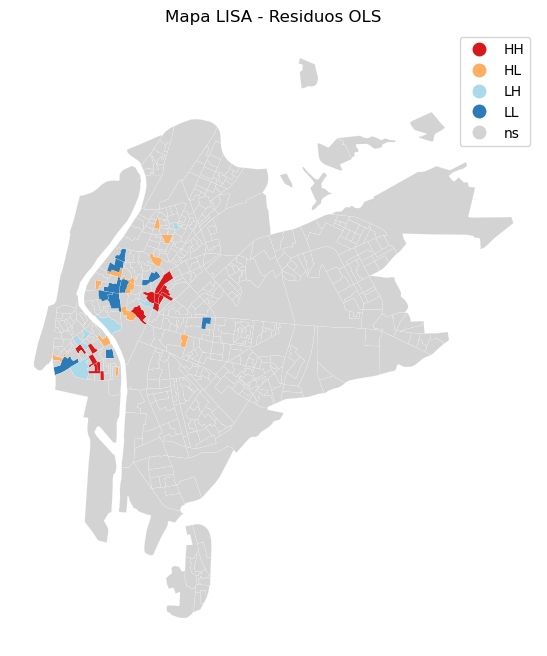

In [129]:
# --- LISA (Local Moran's I) ---
lisa = Moran_Local(residuos_gwr, w)

# Añadimos resultados al GeoDataFrame
data["lisa_cluster"] = lisa.q
data["lisa_pvalue"] = lisa.p_sim

# --- Mapa LISA ---
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
lisa_cluster(lisa, data, p=0.05, ax=ax)  # Solo muestra clusters significativos (p<0.05)
ax.set_title("Mapa LISA - Residuos OLS")
plt.show()

# Interpretación de lisa.q:
# 1 = HH (alta con alta) (Clúster positivo (hot spot))
# 2 = LH (baja con alta) (Valor atípico (low surrounded by high))
# 3 = LL (baja con baja) (Clúster positivo (cold spot))
# 4 = HL (alta con baja) (Valor atípico (high surrounded by low))
# 5 = ns (no significativo) ((sin evidencia de patrón espacial local)